In [1]:
import TraceDisplay as TD
from TraceDisplay import BOKEH_RENDERER
import os
from IPython.core.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Loading BokehJS ...

In [2]:
# Chose a .tar
path_to_tar = ! find ../trace -name *.tar | grep -E 'BENCH=kbuild-sched.*GOVERNOR=schedutil.*MONITORING=trace-cmd.*schedlog' | head -n 1
path_to_tar = path_to_tar[0]
path_to_tar

'../trace/HOST=ryzen/BENCH=kbuild-sched/CMDLINE=default/GOVERNOR=schedutil/MONITORING=trace-cmd/16-5.4-schedlog-ftraced/1.tar'

In [3]:
# Get its .h5
path_to_h5 = os.path.splitext(path_to_tar[len('../trace/'):])[0] + '.h5'
path_to_dat = os.path.splitext(path_to_h5)[0] + '.dat'
trace = TD.Trace()
if os.path.exists(path_to_h5):
    trace.load(path_to_h5)
else:
    # Extract .dat and convert to .h5
    ! mkdir -p $(! dirname $path_to_dat)
    path_trace_dat_tgz = ! tar tf $path_to_tar | grep trace.dat.tgz | head -n 1
    path_trace_dat_tgz=path_trace_dat_tgz[0]
    path_trace_dat = ! tar -O -xf $path_to_tar $path_trace_dat_tgz | tar ztf - | grep trace.dat | head -n 1
    path_trace_dat = path_trace_dat[0]
    ! tar -O -xf $path_to_tar $path_trace_dat_tgz | tar -O -xzf - $path_trace_dat > $path_to_dat
    trace.load(path_to_dat)
    trace.save(path_to_h5)
    os.remove(path_to_dat)
trace.keys()

['/sched_wake_idle_without_ipi',
 '/sched_wakeup_new',
 '/sched_waking',
 '/sched_process_wait',
 '/sched_process_exec',
 '/sched_wakeup',
 '/sched_rq_size_change',
 '/sched_process_free',
 '/sched_switch',
 '/sched_process_fork',
 '/sched_tick',
 '/sched_migrate_task',
 '/sched_process_exit',
 '/sched_stat_runtime']

In [4]:
# Shift timestamps
tmin = min([min(trace[k].index) for k in trace])
tmax = max([max(trace[k].index) for k in trace])
print((tmax-tmin)/1e9)
for k in trace:
    trace[k].index = trace[k].index - tmin

7.983065446


In [5]:
# Find producer/consumer pattern with block, wakeup unblock events
def track_block_wakeup_unblock(trace, block, **kwargs):
    pid = block['prev_pid']
    block_time = block.name
    unblock_idx = trace['sched_switch'].index.searchsorted(block_time)
    query_unblock = trace['sched_switch'].iloc[unblock_idx:].query('next_pid == %d' % (pid))
    if len(query_unblock) == 0:
        # Out of the trace
        return None
    # Get first unblock after block
    unblock = query_unblock.iloc[0]
    unblock_time = unblock.name
    wakeup_idx = trace['sched_wakeup'].index.searchsorted(unblock_time)
    query_wakeup = trace['sched_wakeup'].iloc[:wakeup_idx].query('pid == %d' % (pid))
    if len(query_wakeup) == 0:
        raise Exception(kwargs)
    # Get last wakeup before unblock
    wakeup = query_wakeup.iloc[-1]
    return {
        'block'   : block,
        'wakeup'  : wakeup,
        'unblock' : unblock,
    }

In [6]:
# %%time
def compute_results(trace):
    # S == INTERRUPTIBLE
    # D == UNINTERRUPTIBLE
    block = trace['sched_switch'].query('prev_state == "S" | prev_state == "D"')
    results = {}
    total = 0
    n = len(block)
    print('n=%d'%n)
    for i in range(n):
        blocki = block.iloc[i]
        pattern = track_block_wakeup_unblock(trace, blocki, i=i)
        if pattern:
            total += 1
            for k,v in pattern.items():
                results.setdefault(k,[]).append(v)
    print('total=%d'%total)
    results = {k:pd.DataFrame(v) for k,v in results.items()}
    for k,v in results.items():
        v['i'] = np.arange(total)
        v.index.name = 'timestamp'
    return results
results = TD.Trace()
if os.path.exists('track_block_wakeup_unblock.h5'):
    results.load('track_block_wakeup_unblock.h5')
else:
    results.df = compute_results(trace)
    results.save('track_block_wakeup_unblock.h5')

In [7]:
# for k,v in results.items():
#     print(k)
#     display(v)

In [8]:
def shape(key, df):
    def func(df):
        df = df[key]
        timestamp = np.array(df.index, dtype=float)
        cpu = np.array(df['cpu'], dtype=float)
        i = np.array(df['i'], dtype=int)
        pid = np.array(df['common_pid'], dtype=int)
        return {
            'x0' : timestamp,
            'x1' : timestamp,
            'y0' : cpu,
            'y1' : cpu + 0.5,
            'i'  : i,
            'pid' : pid,
        }
    return (key, func)
shapes = [shape(k, results) for k in results]

In [9]:
image = TD.Image()
image.build(results, shapes)
ci = TD.ColoredImage(image)
HTML(ci.html_legend())

In [10]:
def callback(xmin, xmax, ymin, ymax):
    display(results.timeline((xmax+xmin)*.5, tmin=xmin, tmax=xmax))
    display(trace.timeline((xmax+xmin)*.5, tmin=xmin, tmax=xmax))
br = TD.BokehRenderer()
br.notify_update.append(callback)
br.show()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEJ1dHRvbihkZXNjcmlwdGlvbj11J1J1biBJbnRlcmFjdCcsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCBPdXRwdXQoKSksIF9kb21fY2xhc3Nlcz0odSd3aWTigKY=


(5440.0, 7982990776.0)
(0, 7.5)


,common_comm,common_flags,common_pid,common_preempt_count,cpu,event,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state,i,comm,pid,prio,success,target_cpu
timestamp,,,,,,,,,,,,,,,,,,,
3970910892,ksoftirqd/5,1,49,2,5,sched_switch,swapper/5,0.0,120.0,ksoftirqd/5,49.0,120.0,S,7384,NaN,NaN,NaN,NaN,NaN
3970917472,ksoftirqd/1,1,21,2,1,sched_switch,swapper/1,0.0,120.0,ksoftirqd/1,21.0,120.0,S,7385,NaN,NaN,NaN,NaN,NaN
3970930742,ksoftirqd/2,1,28,2,2,sched_switch,swapper/2,0.0,120.0,ksoftirqd/2,28.0,120.0,S,7386,NaN,NaN,NaN,NaN,NaN
3984213489,<idle>,37,0,4,3,sched_wakeup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7358,ksoftirqd/3,35.0,120.0,1.0,3.0
3984219489,ksoftirqd/0,1,9,2,0,sched_switch,rcu_preempt,11.0,98.0,ksoftirqd/0,9.0,120.0,S,7387,NaN,NaN,NaN,NaN,NaN
3984223559,ksoftirqd/4,1,42,2,4,sched_switch,swapper/4,0.0,120.0,ksoftirqd/4,42.0,120.0,S,7388,NaN,NaN,NaN,NaN,NaN
3984228359,<idle>,1,0,2,3,sched_switch,ksoftirqd/3,35.0,120.0,swapper/3,0.0,120.0,R,7358,NaN,NaN,NaN,NaN,NaN
3984229459,ksoftirqd/5,1,49,2,5,sched_switch,swapper/5,0.0,120.0,ksoftirqd/5,49.0,120.0,S,7389,NaN,NaN,NaN,NaN,NaN
3984229519,ksoftirqd/1,1,21,2,1,sched_switch,swapper/1,0.0,120.0,ksoftirqd/1,21.0,120.0,S,7390,NaN,NaN,NaN,NaN,NaN


,common_comm,common_flags,common_pid,common_preempt_count,cpu,event,comm,pid,prio,success,...,runtime,vruntime,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state,freq
timestamp,,,,,,,,,,,,,,,,,,,,,
3984242609,ksoftirqd/3,16,35,0,3,sched_process_free,mkdir,5630.0,120.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984247289,ksoftirqd/3,16,35,0,3,sched_process_free,sed,5631.0,120.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984252259,ksoftirqd/3,16,35,0,3,sched_process_free,mv,5632.0,120.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984259919,ksoftirqd/3,1,35,2,3,sched_stat_runtime,ksoftirqd/3,35.0,NaN,NaN,...,36200.0,1.742080e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984261249,ksoftirqd/3,1,35,2,3,sched_rq_size_change,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984263239,ksoftirqd/3,1,35,2,3,sched_switch,NaN,NaN,NaN,NaN,...,NaN,NaN,swapper/3,0.0,120.0,ksoftirqd/3,35.0,120.0,S,NaN
3987537401,<...>,9,5635,1,7,sched_stat_runtime,cc1,5635.0,NaN,NaN,...,3316282.0,8.181981e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3987542251,<...>,9,5635,1,7,sched_tick,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1256647.0
3990871153,<...>,9,5635,1,7,sched_stat_runtime,cc1,5635.0,NaN,NaN,...,3318812.0,8.185300e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


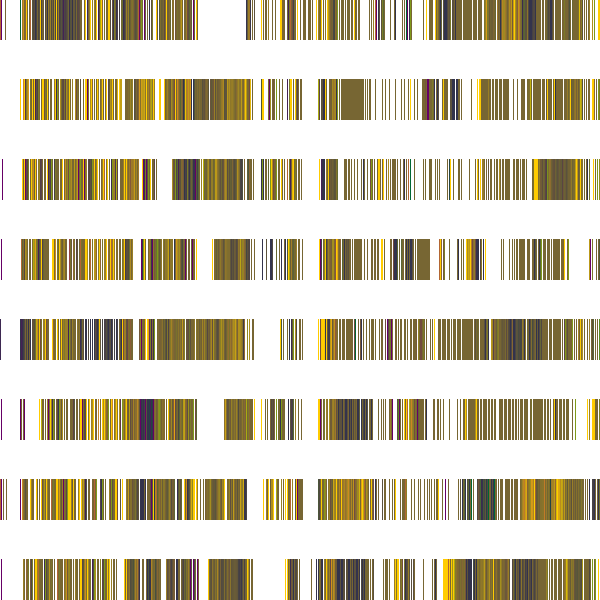

In [11]:
br.render(ci)
display(br.image)

In [12]:
trace['sched_process_exec'].query('pid == 5625')

,common_comm,common_flags,common_pid,common_preempt_count,cpu,event,filename,old_pid,pid
timestamp,,,,,,,,,
3895580091,<...>,0,5625,0,5,sched_process_exec,/usr/bin/sed,5625,5625


In [ ]:
# Looks like its a `sed some pattern somefile | sha1sum`